# Parallelization in Python

Notes from a workshop organized by Dutch e-science centre .

12-13.04.2021


# Part 1: ways of speeding-up code
Running example (will be used fo compare different parallelization solutions).

Calculating Pi using Monte Carlo sampling and standard Python functions

In [2]:
import random
random.uniform(-1, 1)

def calc_pi(N):
    """Computes the value of pi using N random samples """
    r = 1 # # set radius of circle
    M = 0 # initialise M
    for i in range(N):
        
        # n times well take a sample
        x = random.uniform(-r,r)
        y = random.uniform(-r,r)
        
        # circle; x^2 + y^2 = r^2
        if x**2 + y**2 < r**2:
            M += 1
        
    return 4*M/N
calc_pi(10**5)

3.14272

# 1. Vectorization

the easiest way to speed up the calculations is by vectorization: instead of using a for loop, we use vectors, and in this way we can carry out the calculations at each vector entry (here  - sample) at the same time.

In [3]:
import numpy as np

def calc_pi_np(N):
    pts = np.random.uniform(-1, 1, (2, N))
    M = np.count_nonzero((pts ** 2).sum(axis=0) < 1.0)
    return 4 * M / N
    
calc_pi_np(10**5)

3.13344

#### Comparison:
An easy way to time your code is to use '%timeit' magic from jupyter notebook.

In [4]:
%timeit -r 1 calc_pi(10**7)
%timeit -r 1 calc_pi_np(10**7)

13.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
315 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


However, the disadvantage of vectorization is that we need to store the whole vector in memory. We can see the difference by running the memory profiler:

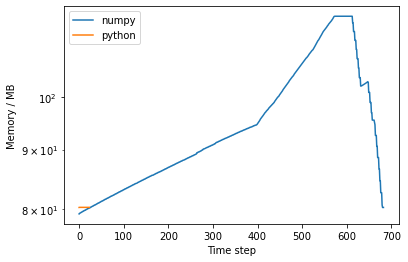

In [6]:
from memory_profiler import memory_usage
import matplotlib.pyplot as plt

memory_numpy = memory_usage(lambda: calc_pi_np(10**6), interval=0.0)
memory_python = memory_usage(lambda: calc_pi(10**6), interval=0.05)

plt.semilogy(memory_numpy, label='numpy')
plt.semilogy(memory_python, label='python')
plt.xlabel('Time step')
plt.ylabel('Memory / MB')
plt.legend()
plt.show()

# 2. Paralel numpy with Dask

Numpy can be sped up with dask, whcih constructs computational graph, and distributes the calculations

In [8]:
import dask.array as da

def calc_pi_da(N):
    pts = da.random.uniform(-1, 1, (2, N))
    M = da.count_nonzero((pts ** 2).sum(axis=0) < 1.0)
    return (4 * M / N).compute()     # to execute the calculations over the graph,
                                     #you need to use .compute() at the end
    
calc_pi_da(100000)

3.13976

In [ ]:
%timeit -r 1 calc_pi(10**7)
%timeit -r 1 calc_pi_np(10**7)
%timeit -r 1 calc_pi_da(10**7)

In [ ]:
def pi_dask_mem():
     calc_pi_da(10**7)

def pi_numpy_mem():
     calc_pi_np(10**7)


        
memory_numpy = memory_usage(pi_numpy_mem, interval = 0.01) 
memory_dask = memory_usage(pi_dask_mem, interval = 0.01) 

plt.plot(memory_numpy, label = 'numpy')
plt.plot(memory_dask, label = 'dask')

plt.xlabel('Time step')
plt.ylabel('Memory / MB')
plt.legend()
plt.show()

# 3. Numba

An alternative way to speed-up calculations is by using Numba, which optimizes the code at the compilation level. Works best for pure python. Example

In [ ]:
import numba

@numba.jit             #simply add this line to change to numba
def sum_range_numba(a):
    x = 0
    for i in range(a):
        x += i
    return x

%timeit sum(range(10**8))
%timeit sum_range_numba(10**8)

In [ ]:
@numba.jit
def calc_pi_numba(N):
    """Computes the value of pi using N random samples."""
    M = 0
    for i in range(N):
        # take a sample
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        
        if x**2 + y**2 < 1.0:
            M += 1
            
    return 4 * M/N
    
%timeit calc_pi_numba(10**7)

In [ ]:
%timeit -r 1 calc_pi(10**7)
%timeit -r 1 calc_pi_np(10**7)
%timeit -r 1 calc_pi_da(10**7)

so in this case, pure numba-recompiled code beats parelelization ad vectorization. This is because the former two methods require additional time whcih results in overhead, which can kill speed-ups in case of smaller jobs.

# 4. Multi-threading

In [ ]:
import queue
import threading

# Number of times to execute calc_pi_numba
ncalc = 10
# Number of threads to launch
ncpus = 4
# Input values
input_range = [10**6] * ncalc

# We need to define a worker function that fetches jobs from the queue.
def worker(q):
    while True:
        try:
            x = q.get(block=False)
            print(calc_pi_numba(x), end=' ', flush=True)
        except queue.Empty:
            break
            
# Create the queue, and fill it with input values
work_queue = queue.Queue()
for n_samples in input_range:
    work_queue.put(n_samples)
    
# Create a number of threads
threads = [threading.Thread(target=worker, args=(work_queue, )) for i in range(ncpus)]


In [ ]:
%%time

# Start the threads
for t in threads:
    t.start()
    
# Wait until all of them are done
for t in threads:
    t.join()
    
print()

but, there is not much speed-up because of GIL (Global interpreter locks) 
so effectively, python functions wait for each other to complete their. 

This could be circumvented with multiprocessing, which basically uses several python interpreters in parallel. However, then the functions cannot share memory.

Alternatively, GIL can be circumvented with numba

In [ ]:
@numba.jit(nogil=True, nopython=True)
def calc_pi_numba_nogil(N):
    """Computes the value of pi using N random samples."""
    M = 0
    for i in range(N):
        # take a sample
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        
        if x**2 + y**2 < 1.0:
            M += 1
            
    return 4 * M/N
    
%timeit calc_pi_numba(10**7)

# Part 2: Parallel design patterns with Dask



To implement parallel data-processing design with dask, usually we use '**bag**' to store data as python collections and is cucial for parallel processing (functions such as map, groupby etc.)

https://docs.dask.org/en/latest/bag.html

In [ ]:
import dask.bag as db
bag = db.from_sequence(['good', 'morning'])
bag

## 1. Map
now we can define a function, which can be applied on an element of the bag, using 'map'


In [ ]:
def shout(word):
    return word + '!'

#to apply the function on each element, we use map() function
# you can visualize the computational graph as follows:
bag.map(shout).visualize()


In [ ]:
bag.map(shout).compute()

## 2.  Filter
in a similar way, we can apply custom filtering, where the filtering condition is specified by our function:

In [ ]:
def contains_d(word):
    return 'd' in word

contains_d('good')

bag.filter(contains_d).compute()

## 3. Sum
example: summing numbers

In [ ]:
bag = db.from_sequence(range(10))
bag.reduction(sum, sum).visualize()


In [ ]:
bag.reduction(sum, sum).compute()


## 4. Groupby

In [ ]:
def is_even(x):
    return x % 2 == 0
    
bag.map(is_even).compute()
bag.groupby(is_even).compute()

# Example workflow:
Counting words in a list of texts

In [ ]:
from nltk.stem.snowball import PorterStemmer

stemmer = PorterStemmer()
#Stemmer: finds stem of a word, ex:
#stemmer.stem('dancing') #-> 'danc'
#stemmer.stem('danced')

def good_word(w):
    return len(w) > 0 and not any(i.isdigit() for i in w)
    
def clean_word(w):
    return w.strip("*!?.:;'\",“’‘”()_").lower()
    
text = 'All work and no play makes jack a dull boy'
words = set()

In [ ]:
import requests
def load_url(url):
    response = requests.get(url)
    return response.text

In [ ]:
# a list of texts
urls = [
 'https://www.gutenberg.org/files/764/764-0.txt',
 'https://www.gutenberg.org/files/15/15-0.txt', 
 'https://www.gutenberg.org/files/1661/1661-0.txt',
 'https://www.gutenberg.org/files/84/84-0.txt',
 'https://www.gutenberg.org/files/345/345-0.txt',
 'https://www.gutenberg.org/files/768/768-0.txt',
 'https://www.gutenberg.org/files/1342/1342-0.txt',
 'https://www.gutenberg.org/files/11/11-0.txt',
 'https://www.gutenberg.org/files/61262/61262-0.txt'
]



In [ ]:
bag = db.from_sequence(urls)


In [ ]:
computation = bag.map(load_url)\
                 .str.split()\
                 .flatten()\
                 .map(clean_word)\
                 .filter(good_word)\
                 .map(stemmer.stem)\
                 .distinct()\
                 .count()
computation.visualize()

In [ ]:
count = computation.compute()
print(f'These texts contain {count} unique words')